# Meridional Overturning Circulation

This notebook shows a simple example of calculating the zonally-averaged global meridional overturning circulation, using output from either `MOM5` or `MOM6`. We  compute the overturning circulation both in density-latitude and depth-latitude space.

**Requirements:** The `conda/analysis3-24.01` (or later) module on ARE. We recommend an ARE session with more than 14 cores to make these computations. Ideally, use a whole Gadi compute node from `normal`, i.e., 48 cores.


#### ‼️ ⚠️ 🚨 Caveats 🚨 ⚠️ ‼️
The computations presented in this recipe suffer from _two_ issues in the Arctic ocean region, North of 65ᵒN:

1. The overturning metrics in this notebook do not use correct zonal averaging in the tripole region, north of 65°N! See https://cosima-recipes.readthedocs.io/en/latest/Recipes/True_Zonal_Mean.html for a recipe explainig how to properly average quantities in the zonal direction when the North of 65ᵒN.

2. The notion of vector quantities is distorted North of 65ᵒN. Because North of 65ᵒN the grid cells' local `x`- and `y`- directions do not align with lines of constant latitude and longitude. Thus we need to rotate the volume transports in the local `x`- and `y`-directions to obtain the corresponding transports in the zonal and meridional direction. For that reason, **all computations done in this notebook are wrong North of 65ᵒN**. We do not show anything North of 65ᵒN in any of the plots. See https://github.com/COSIMA/cosima-recipes/issues/510 for more details.


With the above in mind, let's start by loading the requisite libraries:

In [1]:
import cosima_cookbook as cc
import numpy as np

from dask.distributed import Client

import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg

import matplotlib.pyplot as plt
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34267,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:36973,Total threads: 1
Dashboard: /proxy/38129/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:35133,


This notebook is designed to use `cf-xarray` and a dictionary of `querying.getvar` arguments to load the correct variables independent of whether you are using a `MOM5` or `MOM6` model. 

In [3]:
session = cc.database.create_session()

Next, choose an experiment. The dictionary below denotes which experiment we want to use for each model.

We can choose experiments at any resolution. For MOM5-based runs, they can be with or without Gent-McWilliams eddy parameterisation.

For this example, we are using 1 year of the 0.1° control simulations. If you want to increase the resolution or integrate over a longer time you might need a bigger ARE session!

In [4]:
model_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "variable": "ty_trans_rho",
        "start_time": "2152-01-01",
        "end_time": "2152-12-31",
        "chunks": {},
    },
    "mom6": {
        "expt": "global-01-v3",
        "variable": "vmo",
        "start_time": "2010-01-01",
        "end_time": "2010-12-31",
        "frequency": "1 monthly",
        "chunks": {},
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}

setting the dictionary for the remapping function:

In [5]:
remap_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "frequency": "1 monthly",
        "rho_2" : "pot_rho_2",
        "depth" : "st_ocean",
        "latitude_c": "yt_ocean",
        "latitude_b": "yu_ocean",
        "latitude_bsect": "grid_yu_ocean",
        "chunks": {},
    },
    "mom6": {
        "expt": "global-01-v3",
        "frequency": "1 monthly",
        "rho_2" : "rhopot2",
        "depth" : "z_l",
        "latitude_c": "yh",
        "latitude_b": "yq",
        "latitude_bsect": "yq",
        "chunks": {},
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}

MOM5: Load up `ty_trans_rho` and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that the [GM parameterisation](https://www2.cgd.ucar.edu/staff/gent/gm20.pdf) is switched on and load that as well, so that the parameterised eddy advection is included. Most ACCESS-OM2 and MOM6 simulations save transport with units of kg/s - convert to Sv.

In [6]:
def load_streamfunction(model):
    expt = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]

    psi = cc.querying.getvar(session=session, **model_args[model])
    psi = psi.pint.quantify()
    psi = psi.sel(time=slice(start_time, end_time))
    psi = psi.cf.sum("longitude")

    psiGM = 0 * psi.copy(deep=True)

    varlist = cc.querying.get_variables(session, expt)

    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time=start_time, end_time=end_time, chunks = chunks)
        psiGM = psiGM.pint.quantify()
        psiGM = psiGM.sel(time=slice(start_time, end_time))
        psiGM = psiGM.cf.sum("longitude")
    else:
        GM = False
    
    ρ0 = 1025 * ureg.kilogram / ureg.meter**3 # mean density of sea-water
    
    # convert mass transport -> volume transport and then convert units -> Sv
    psi = (psi / ρ0).pint.to('sverdrup')
    psiGM = (psiGM / ρ0).pint.to('sverdrup')
    
    return psi, psiGM, GM

Now, we define a function that cumulatively sums the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [7]:
def sum_in_vertical(psi, psiGM, GM):
    psi_avg = psi.cf.cumsum("vertical").mean("time") - psi.cf.sum("vertical").mean("time")

    if GM:
        psi_avg = psi_avg + psiGM.cf.mean("time")

    psi_avg.load()

    return psi_avg

Let's load everything from a MOM5 model.

In [8]:
model = 'mom5'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

## Plotting

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution.

In [9]:
def levels_and_colorbarticks(max_value):
    """ Return the levels and the colorbarticks for the streamfunction plot.
    It may seem complicated but the truth is we just want to avoid the 0 contour
    so that the plot looks soothing to the eye"""

    levels =  np.hstack((np.arange(-max_value, 0, 2), np.flip(-np.arange(-max_value, 0, 2))))
    cbarticks = np.hstack((np.flip(-np.arange(3, max_value, 6)), np.arange(3, max_value, 6)))

    return levels, cbarticks

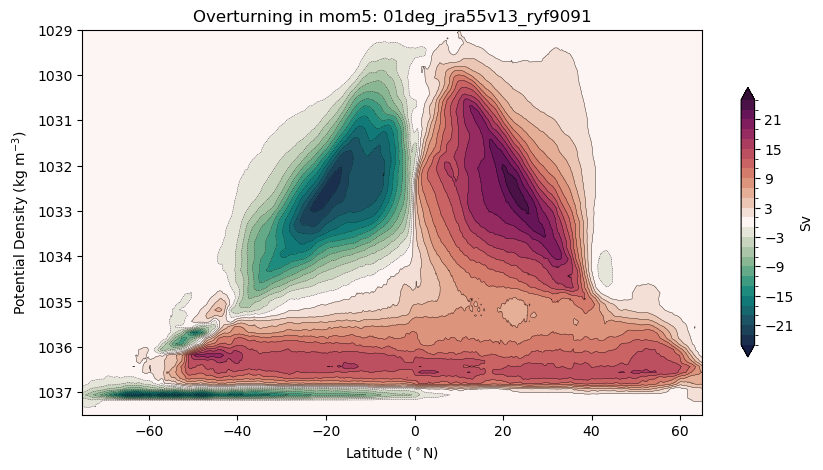

In [10]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg.plot.contour(levels=levels,
                     colors='k',
                     linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1029))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Now let's define a function to remap the vertical dimension into depth coordinates.

In [11]:
def remap_depth(remap_args, model_args, psi_avg, session, model):

    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]

    rho2 = cc.querying.getvar(experiment, remap_args[model]["rho_2"],
                              session,
                              start_time = start_time,
                              end_time = end_time, 
                              chunks = model_args[model]["chunks"]).astype('float64')
    rho2 = rho2.pint.quantify()
    
    #Mask the Mediteranean
    rho2 = rho2.cf.where(((rho2.cf['longitude'] < 0) | (rho2.cf['longitude'] > 45) ) |
                         ((rho2.cf['latitude'] < 10) | (rho2.cf['latitude'] > 48))
                        )

    rho2_time_mean = rho2.sel(time=slice(start_time, end_time)).mean('time')

    rho2_zonal_mean = rho2_time_mean.cf.mean("longitude").load()
    
    # nmin is the latitude index that corresponds to 78S
    nmin = int(list(rho2_zonal_mean.cf['latitude'].values).index(rho2_zonal_mean.cf.sel(latitude=-78, method='nearest').cf['latitude']))

    nmax = np.size(rho2_zonal_mean.cf['latitude'])
        
    psi_depth = 0 * psi_avg.copy(deep=True)
    psi_depth = psi_depth.pint.dequantify()

    for ii in range(nmin, nmax):
        rho1 = rho2_zonal_mean.cf.isel(latitude=ii)
        rho1v = rho1.copy()
        z = rho1.cf['vertical']
        rho1 = rho1.rename({rho1.cf['vertical'].name: 'rho_ref'})
        rho1['rho_ref'] = np.array(rho1v)
        rho1.name = rho2_zonal_mean.cf['vertical'].name
        rho1.values = np.array(z)
        
        rho1 = rho1.isel(rho_ref = ~np.isnan(rho1.rho_ref)).drop_duplicates(dim='rho_ref', keep='first')

        rho1 = rho1.interp(rho_ref = psi_avg.cf['vertical'].values,
                           kwargs={"bounds_error": False, "fill_value": (0, 6000)})
        psi_depth[:, ii] = rho1.rename({'rho_ref': psi_avg.cf['vertical'].name})

    psi_avg2 = psi_avg.rename({remap_args[model]["latitude_bsect"]: 'latitude_b'}) # purely for automatic renaming later

    new_psi_avg = xr.DataArray(data = psi_avg2.values,
                               dims = [remap_args[model]["rho_2"], 'latitude_b'],
                               coords = dict(latitude_b=(["latitude_b"], psi_avg2["latitude_b"].values),
                                             depth=([remap_args[model]["rho_2"], "latitude_b"], psi_depth.values)),
                               attrs = psi_avg.attrs)

    new_psi_avg.attrs['units'] = psi_avg.pint.units
    
    new_psi_avg = new_psi_avg.pint.quantify()

    new_psi_avg = new_psi_avg.rename({'latitude_b': remap_args[model]["latitude_b"]})

    psi_depth = psi_depth.pint.quantify()
    
    return psi_depth, new_psi_avg

In [12]:
psi_depth, new_psi_avg = remap_depth(remap_args, model_args, psi_avg, session, model)

## Plotting

Let's plot the streamfunction along depth

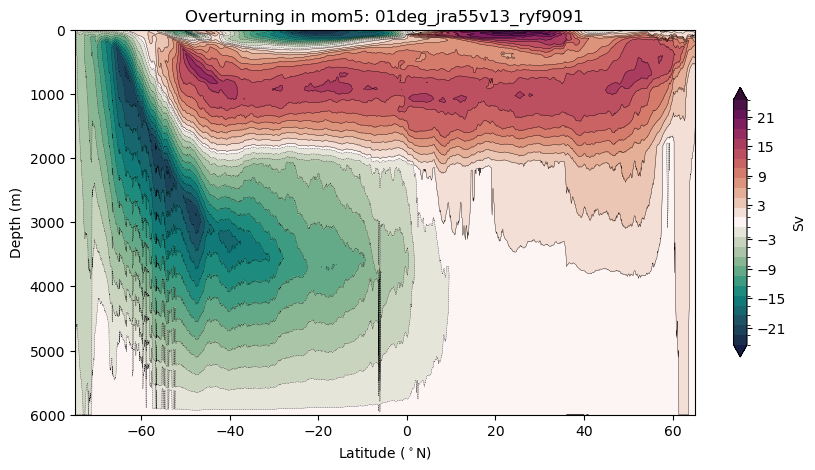

In [13]:
plt.figure(figsize=(10, 5))

max_psi = 24.5 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

new_psi_avg.plot.contourf(y="depth",
                          levels=levels,
                          cmap=cm.cm.curl,
                          extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

new_psi_avg.plot.contour(y="depth",
                         levels=levels,
                         colors='k',
                         linewidths=0.25)

plt.gca().invert_yaxis()


plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Now let's do it again using output from a MOM6 model. Easy!

In [14]:
model = 'mom6'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

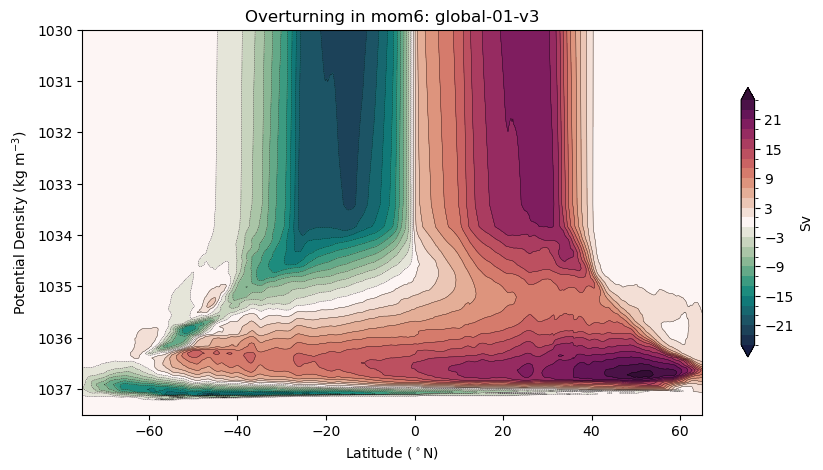

In [15]:
plt.figure(figsize=(10, 5)) 

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg.plot.contour(levels=levels,
                     colors='k',
                     linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1030))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

In [16]:
stretching_factor = 6 # A power value to set the stretching

ρmin = psi_avg.cf['vertical'].min()

psi_avg_plot = psi_avg.assign_coords(
    {
        psi_avg.cf["vertical"].name: (psi_avg.cf["vertical"] - ρmin)**stretching_factor
    }
)

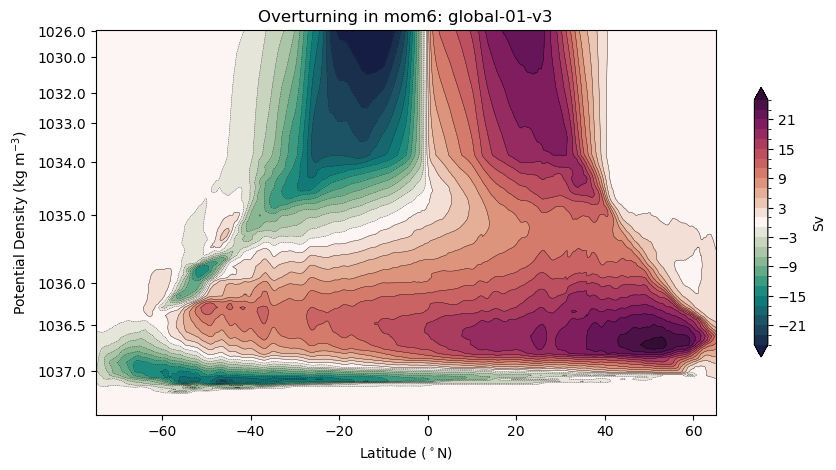

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

yticks = np.array([1026, 1030, 1032, 1033, 1034, 1035, 1036, 1036.5, 1037])

psi_avg_plot.plot.contourf(levels=levels, 
                           cmap=cm.cm.curl,
                           extend='both',
                           cbar_kwargs={'shrink': 0.7,'label': 'Sv', 'ticks': cbarticks})

psi_avg_plot.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().set_yticks((yticks - ρmin.values)**stretching_factor)
plt.gca().set_yticklabels(yticks)

# ylims: a bit less than the minimum and a bit more than the maximum values
plt.gca().set_ylim([((yticks - ρmin.values).min() / 1.1)**stretching_factor, ((yticks - ρmin.values).max() * 1.02)**stretching_factor])
plt.gca().invert_yaxis()

plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

Remapping the `mom6` streamfunction into depth coordinates.

In [18]:
psi_depth, new_psi_avg = remap_depth(remap_args, model_args, psi_avg, session, model)

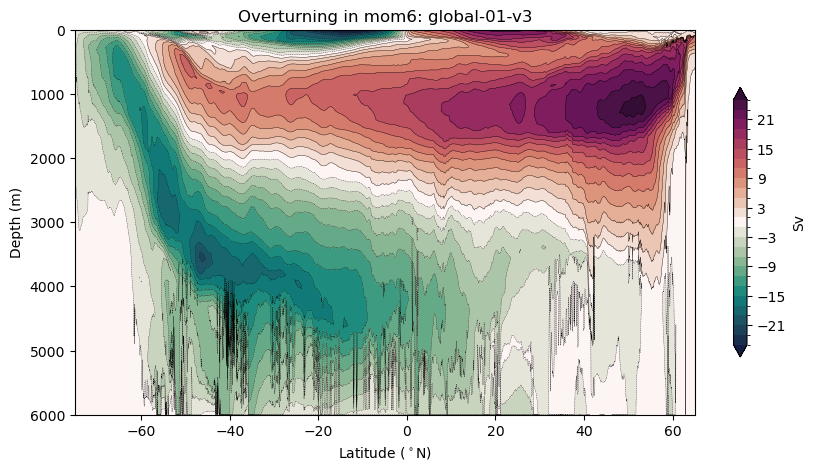

In [19]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

levels, cbarticks = levels_and_colorbarticks(max_psi)

new_psi_avg.plot.contourf(y="depth",
                          levels=levels,
                          cmap=cm.cm.curl,
                          extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

new_psi_avg.plot.contour(y="depth",
                         levels=levels,
                         colors='k',
                         linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 65]) # calculations are wrong for region north of 65ᵒN
plt.title(f'Overturning in {model}: {model_args[model]["expt"]}');

**Note:**

 * We have not included the [parameterised submesoscale contribution](https://www.sciencedirect.com/science/article/abs/pii/S1463500310001290) to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which is where we are primarily interested. To include the parameterised submesoscale contribution in `MOM5`, you would need to use the `ty_trans_submeso` diagnostic.
